In [1]:
%cd '/home/urbanaq/cams_downscaling'

/home/urbanaq/cams_downscaling


In [2]:
from cams_downscaling.utils import read_config

config = read_config('/home/urbanaq/cams_downscaling/config')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from pathlib import Path

In [4]:
variable = 'NO2'
region = 'italy'

bbox = config['regions'][region]['bbox']

bbox

{'min_lat': 36.5, 'min_lon': 6.7, 'max_lat': 47.3, 'max_lon': 18.6}

# 0. Preprocesament

1. Temporal resampling datasets 
2. Regriding datasets (Bilinear interpolation)
3. Define Regions of Interest (ROIs) 
4. Generate station permutations for each ROI(X-1/1) 
5. Interpolate stations (X-1) (Nearest neighbours + Kriging) 
6. Add geographical proximity covariates 
7. Add interpolation covariates 

# 1. CAMS data

In [5]:
from cams_downscaling.readers.cams import load_cams

cams_path = config['paths']['cams']
cams_path = Path(cams_path, variable.lower(), region)

#dates = pd.date_range('2022-01-01T00:00:00', '2023-12-31T23:00:00', freq='h')
dates = pd.date_range('2022-01-01T00:00:00', '2022-01-01T23:00:00', freq='h')
cams = load_cams(cams_path, dates=dates)

cams

TimeseriesGridData(
    > Axes:
        - date: 24 elements
        - lat: 108 elements
        - lon: 119 elements
    > Data:
        - no2: (24, 108, 119)
    > Memory: 1.18 MB
)

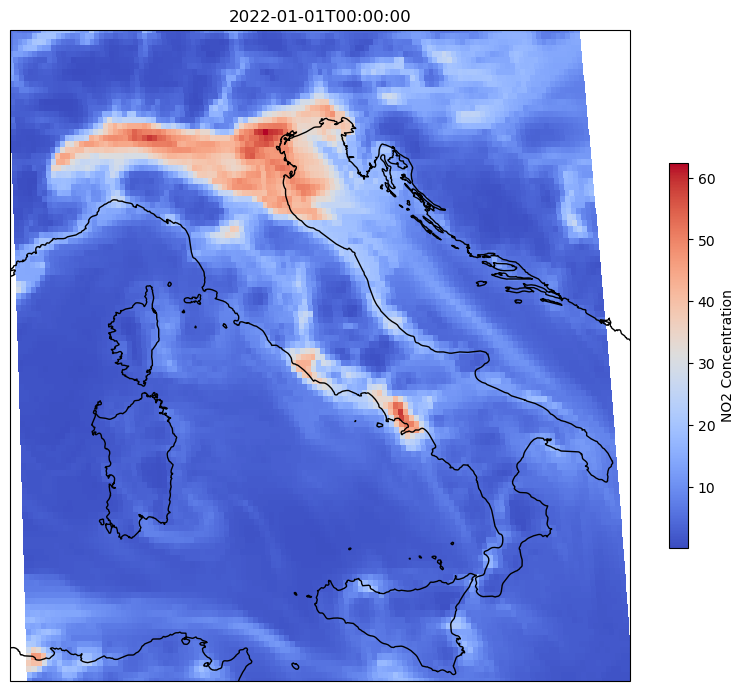

In [6]:
data = cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Define the extent
extent = (cams.lon.min(), cams.lon.max(), cams.lat.min(), cams.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(cams.lon, cams.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

## 1.1. Temporal resampling

CAMS is already in hourly format, so no need to resample

## 1.2. Regridding datasets

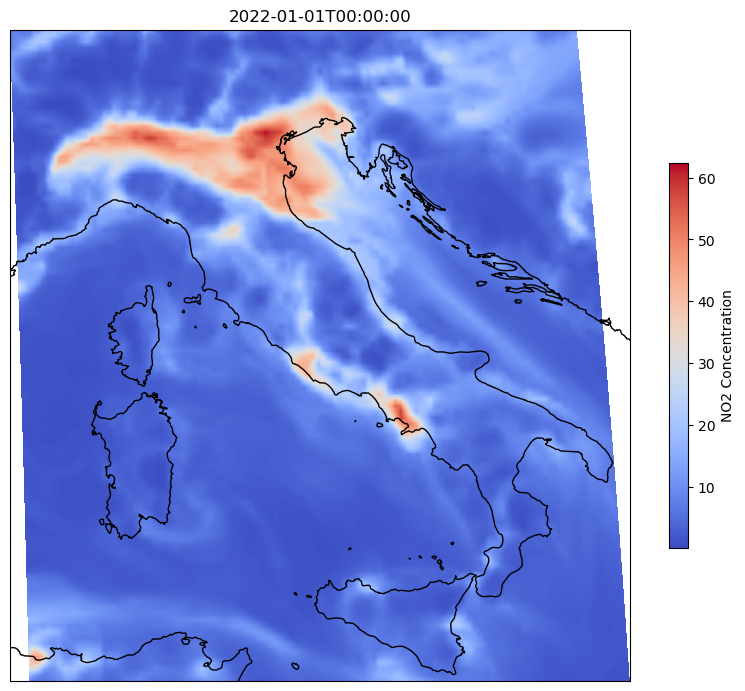

In [7]:
new_resolution = 0.01

new_lat = np.arange(cams.lat.min(), cams.lat.max(), new_resolution)
new_lon = np.arange(cams.lon.min(), cams.lon.max(), new_resolution)

new_cams = cams.interpolate(lat=new_lat, lon=new_lon)
new_data = new_cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(new_lon, new_lat, new_data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

In [8]:
new_cams

TimeseriesGridData(
    > Axes:
        - date: 24 elements
        - lat: 1071 elements
        - lon: 1180 elements
    > Data:
        - no2: (24, 1071, 1180)
    > Memory: 231.41 MB
)

In [9]:
# Finished, delete the cams to free up memory
del cams
del new_cams

# 2. EEA Stations

In [55]:
import pandas as pd

stations = pd.read_csv(
    config['paths']['stations'] + '/stations.csv',
    usecols=["Air Quality Station EoI Code", "Longitude", "Latitude", "Country"],
    index_col="Air Quality Station EoI Code")

stations = stations[
    (stations["Longitude"].between(bbox["min_lon"], bbox["max_lon"])) & 
    (stations["Latitude"].between(bbox["min_lat"], bbox["max_lat"]))]

stations.index.name = 'station'

stations = stations[~stations.index.duplicated(keep='first')]

stations = stations[stations["Country"].isin(['Italy'])].drop(columns=["Country"])

stations

,Longitude,Latitude
station,,
IT0456A,13.2219,43.7142
IT1564A,13.5147,43.6078
IT1589A,13.3217,43.6003
IT1693A,13.5014,43.6144
IT1729A,13.4817,43.4825
...,...,...
IT2061A,12.6364,43.7306
IT2177A,13.8794,42.9444
IT2289A,13.4923,43.6059


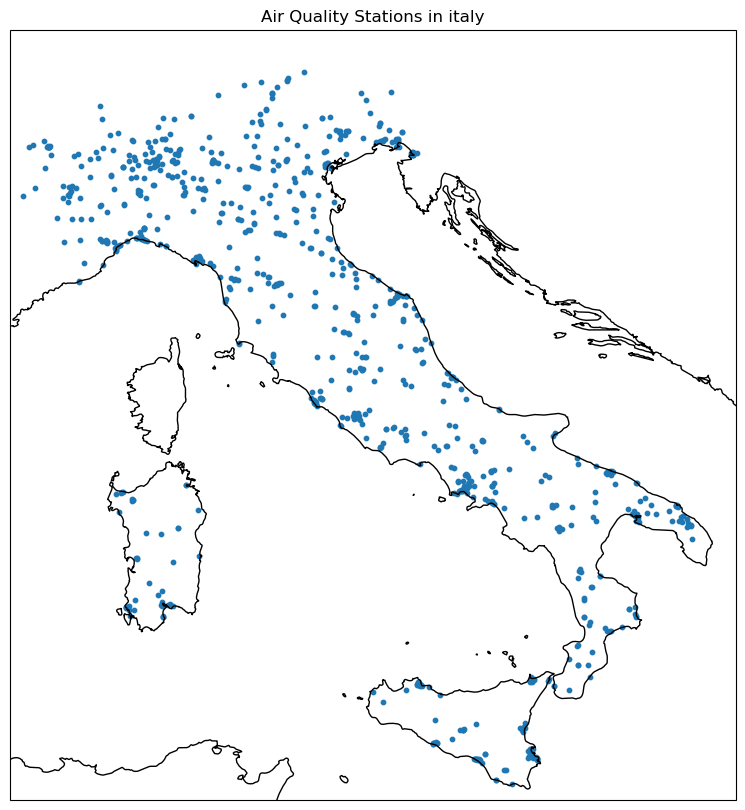

In [56]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title(f"Air Quality Stations in {region}")
plt.show()

In [57]:
observations = pd.read_csv(config['paths']['stations'] + '2022/IT.csv', usecols=['time', 'station', variable], index_col=['time', 'station'], parse_dates=['time'])

# Create a dataframe with all combinations of timestamps and stations
all_combinations = pd.MultiIndex.from_product([
    observations.index.get_level_values('time').unique(),
    observations.index.get_level_values('station').unique()],
    names=['time', 'station']).to_frame(index=False)

observations = pd.merge(all_combinations, observations, on=['time', 'station'], how='left').set_index(['time', 'station'])

# Join the station coordinates
observations = observations.join(stations, how='left', on='station')

observations

NO2  Longitude  Latitude
time                station                                
2022-01-01 00:00:00 IT0063A    2.00000    10.5342   42.9392
                    IT0187A   37.00000    11.6131   44.8425
                    IT02258A  16.66406    11.8335   42.0424
                    IT0267A        NaN     9.4147   45.3294
                    IT0448A        NaN    12.3139   45.4294
...                                ...        ...       ...
2022-10-22 01:00:00 IT2319A   20.00000    12.3231   45.4356
                    IT2320A   20.00000    11.3782   45.4784
                    IT2322A   11.90000    12.6789   42.5723
                    IT2323A    3.06000     8.9490   44.5678
                    IT2324A        NaN    13.6161   45.9365

[5518800 rows x 3 columns]

In [58]:
# Drop observations where NO2 is NaN
observations = observations.groupby('station').filter(lambda x: x['NO2'].notnull().any())

# Drop observations where Latitude is NaN
observations = observations.groupby('station').filter(lambda x: x['Latitude'].notnull().any())

# Drop stations where NO2 is NaN
stations = stations[stations.index.isin(observations.index.get_level_values('station').unique())]

observations

NO2  Longitude  Latitude
time                station                                
2022-01-01 00:00:00 IT0063A    2.00000    10.5342   42.9392
                    IT0187A   37.00000    11.6131   44.8425
                    IT02258A  16.66406    11.8335   42.0424
                    IT0267A        NaN     9.4147   45.3294
                    IT0459A   24.60000    13.3419   43.5989
...                                ...        ...       ...
2022-10-22 01:00:00 IT2318A        NaN    12.7180   37.8825
                    IT2319A   20.00000    12.3231   45.4356
                    IT2320A   20.00000    11.3782   45.4784
                    IT2322A   11.90000    12.6789   42.5723
                    IT2323A    3.06000     8.9490   44.5678

[3249960 rows x 3 columns]

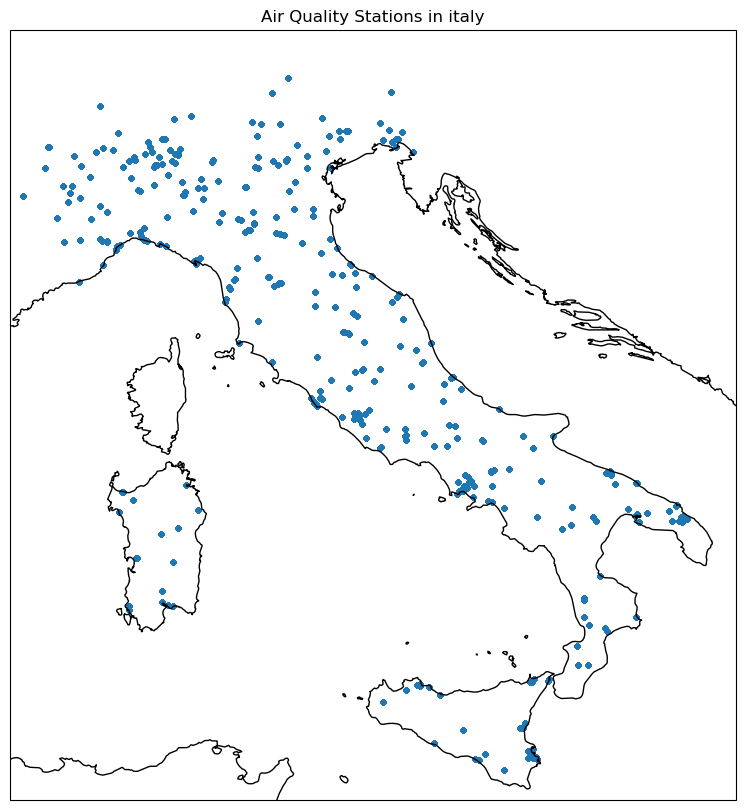

In [59]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(observations.Longitude, observations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title(f"Air Quality Stations in {region}")
plt.show()

## 2.3. Define ROIs

In [60]:
from sklearn.cluster import DBSCAN

# Define the clustering model
dbscan = DBSCAN(eps=0.1, min_samples=5)

# Fit the model
clusters = dbscan.fit_predict(stations[['Longitude', 'Latitude']])
stations.loc[:, 'cluster'] = clusters
stations = stations[stations.cluster != -1]

stations

/tmp/ipykernel_11588/2663937629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.loc[:, 'cluster'] = clusters


,Longitude,Latitude,cluster
station,,,
IT0854A,8.9274,44.4182,0
IT0856A,8.9410,44.4076,0
IT0858A,8.9915,44.3949,0
IT1549A,8.8738,44.5186,0
IT1698A,8.9682,44.4049,0
IT1850A,8.9014,44.4627,0
IT02258A,11.8335,42.0424,1
IT0825A,12.4696,41.9474,2
IT0828A,12.5090,41.8831,2


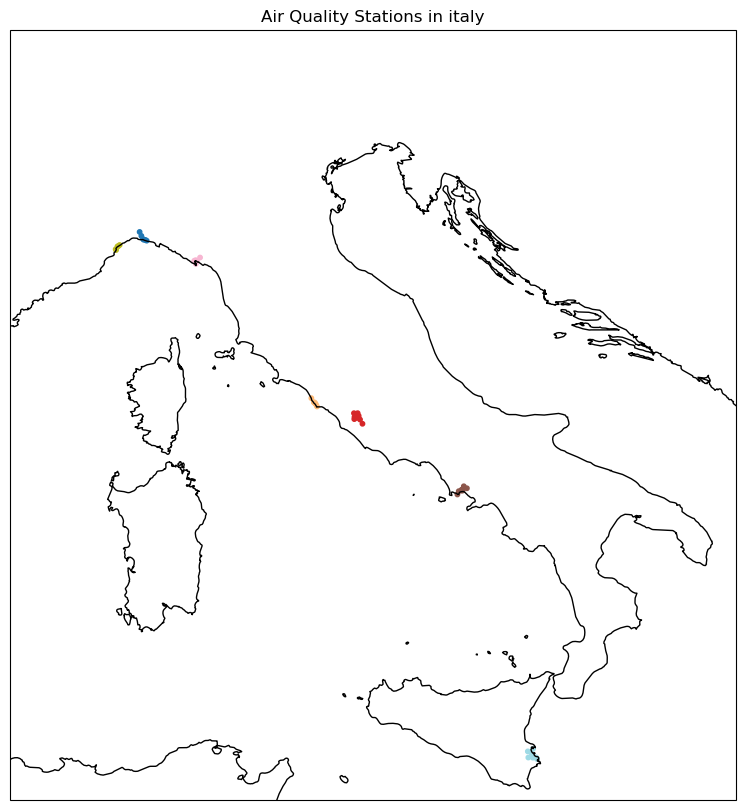

In [61]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
scatter = ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10, c=stations.cluster, cmap='tab20')
plt.title(f"Air Quality Stations in {region}")
plt.show()

In [62]:
region_box = stations.groupby('cluster').agg({'Latitude': ['min', 'max'], 'Longitude': ['min', 'max']})

region_box['n'] = stations.cluster.value_counts()
region_box['area (km²)'] = 111*(region_box['Latitude']['max'] - region_box['Latitude']['min']) * 111*(region_box['Longitude']['max'] - region_box['Longitude']['min'])
region_box['area (hm²)'] = region_box['area (km²)'] * 100
region_box['density (km²)'] = region_box['n'] / region_box['area (km²)']
region_box['density (hm²)'] = region_box['n'] / region_box['area (hm²)']

region_box

Latitude          Longitude           n  area (km²)    area (hm²)  \
             min      max       min      max                                
cluster                                                                     
0        44.3949  44.5186    8.8738   8.9915  6  179.387476  17938.747629   
1        42.0424  42.1600   11.7427  11.8335  6  131.564624  13156.462368   
2        41.7979  41.9477   12.4696  12.6070  9  253.597229  25359.722892   
3        40.7989  40.9146   14.1794  14.3500  8  243.197073  24319.707282   
4        44.0647  44.1547    9.8159   9.9187  7  113.993892  11399.389200   
5        44.2618  44.3329    8.4389   8.5120  5   64.037289   6403.728861   
6        37.0758  37.2184   15.1288  15.2786  7  263.194795  26319.479508   

        density (km²) density (hm²)  
                                     
cluster                              
0            0.033447      0.000334  
1            0.045605      0.000456  
2            0.035489      0.000355  
3            0.032895      0.000329  
4            0.061407      0.000614  
5            0.078080      0.000781  
6            0.026596      0.000266

In [63]:
observations = observations.join(stations['cluster'], on='station', how='inner')

observations

NO2  Longitude  Latitude  cluster
time                station                                         
2022-01-01 00:00:00 IT02258A  16.66406    11.8335   42.0424        1
                    IT0611A        NaN    15.1288   37.1824        6
                    IT0614A        NaN    15.1909   37.1561        6
                    IT0618A        NaN    15.2205   37.2184        6
                    IT0620A        NaN    15.2625   37.0984        6
...                                ...        ...       ...      ...
2022-10-22 01:00:00 IT2264A    4.38911    11.7883   42.0969        1
                    IT2277A   28.10000    14.1794   40.7989        3
                    IT2278A    4.33000     8.5120   44.3329        5
                    IT2286A    9.01000     8.4457   44.2618        5
                    IT2316A        NaN    15.1318   37.0963        6

[420480 rows x 4 columns]

## 2.1. Temporal Resampling

In [64]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def fill_missing_values(observations, variable):
    df = observations.copy()
    df['hour'] = df.index.get_level_values('time').hour
    df['dayofweek'] = df.index.get_level_values('time').dayofweek
    df['weekofyear'] = df.index.get_level_values('time').isocalendar().week.values
    df[f'last_observed_{variable}'] = df.groupby('station')[variable].shift(1).transform(lambda x: x.ffill())
    
    missing = df[df[variable].isnull()]
    df = df.dropna(subset=[variable])
    
    features = ['hour', 'dayofweek', 'weekofyear', 'Longitude', 'Latitude', f'last_observed_{variable}']
    target = variable
    
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = make_pipeline(StandardScaler(), HistGradientBoostingRegressor())
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(f'R² Score: {r2_score(y_test, y_pred)}')
    
    missing = missing.join(
        df.groupby(['station', 'hour', 'dayofweek'])[f'last_observed_{variable}'].mean(),
        on=['station', 'hour', 'dayofweek'],
        rsuffix='_mean')
    
    missing[f'last_observed_{variable}'] = missing[f'last_observed_{variable}'].fillna(missing[f'last_observed_{variable}_mean'])
    
    missing = missing.drop(columns=[f'last_observed_{variable}_mean'])
    
    # Predict the missing values
    missing[variable] = model.predict(missing[features])
    observations = pd.concat([df, missing])[[variable, 'Latitude', 'Longitude', 'cluster']]
    observations = observations.sort_index()
    
    return observations

observations = fill_missing_values(observations, variable=variable)

observations

R² Score: 0.7962935721422989


NO2  Latitude  Longitude  cluster
time                station                                          
2022-01-01 00:00:00 IT02258A  16.664060   42.0424    11.8335        1
                    IT0611A    8.590333   37.1824    15.1288        6
                    IT0614A   19.625444   37.1561    15.1909        6
                    IT0618A   22.034541   37.2184    15.2205        6
                    IT0620A   21.732343   37.0984    15.2625        6
...                                 ...       ...        ...      ...
2022-12-31 23:00:00 IT2264A   23.185680   42.0969    11.7883        1
                    IT2277A   16.700000   40.7989    14.1794        3
                    IT2278A    5.990000   44.3329     8.5120        5
                    IT2286A   16.470000   44.2618     8.4457        5
                    IT2316A    8.262230   37.0963    15.1318        6

[420480 rows x 4 columns]

## 2.4. Generate permutations for each cluster

In [66]:
n=5

permutations = pd.get_dummies(
    observations.groupby(['time', 'cluster'], group_keys=False)
    .apply(lambda x: x.sample(n).assign(i=range(n)), include_groups=False)
    .get('i').astype(str).reindex(observations.index)
).add_prefix('perm_')

permutations

perm_0  perm_1  perm_2  perm_3  perm_4
time                station                                         
2022-01-01 00:00:00 IT02258A   False   False   False   False    True
                    IT0611A    False   False   False   False    True
                    IT0614A    False   False   False   False   False
                    IT0618A    False   False    True   False   False
                    IT0620A    False   False   False    True   False
...                              ...     ...     ...     ...     ...
2022-12-31 23:00:00 IT2264A    False   False   False   False   False
                    IT2277A     True   False   False   False   False
                    IT2278A    False   False   False   False    True
                    IT2286A    False    True   False   False   False
                    IT2316A    False   False   False   False   False

[420480 rows x 5 columns]

In [67]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, 2:3],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=['Latitude', 'Longitude', f'{variable}_obs', f'{variable}_interp', 'dist'])
    
# Apply the function to the dataset
dataset = observations.join(permutations).groupby(['time', 'cluster']).apply(interpolate_points, variable=variable)
dataset = dataset.reset_index().drop(columns=['level_2'])

dataset

/tmp/ipykernel_11588/20304055.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = observations.join(permutations).groupby(['time', 'cluster']).apply(interpolate_points, variable=variable)


,time,cluster,Latitude,Longitude,NO2_obs,NO2_interp,dist
0,2022-01-01 00:00:00,0,44.3949,8.9915,30.790000,49.48000,0.025355
1,2022-01-01 00:00:00,0,44.5186,8.8738,7.380000,28.23000,0.062342
2,2022-01-01 00:00:00,0,44.4049,8.9682,49.480000,30.79000,0.025355
3,2022-01-01 00:00:00,0,44.4182,8.9274,42.270000,39.21000,0.017243
4,2022-01-01 00:00:00,0,44.4076,8.9410,39.210000,42.27000,0.017243
...,...,...,...,...,...,...,...
306595,2022-12-31 23:00:00,6,37.0940,15.2087,9.766690,6.33479,0.053980
306596,2022-12-31 23:00:00,6,37.2184,15.2205,10.544216,7.43356,0.068974
306597,2022-12-31 23:00:00,6,37.1824,15.1288,6.941250,7.43356,0.067440
306598,2022-12-31 23:00:00,6,37.1561,15.1909,7.433560,9.76669,0.064601


# 3. Elevation

In [68]:
from cams_downscaling.readers.topography import load_topography

new_lat = np.arange(bbox["min_lat"], bbox["max_lat"], new_resolution)
new_lon = np.arange(bbox["min_lon"], bbox["max_lon"], new_resolution)

topography = load_topography("/data1/data_prep/nasa_topo/topo.tiff", bbox)
topography = topography.interpolate(lat=new_lat, lon=new_lon)

topography

GridData(
    > Axes:
        - lat: 1080 elements
        - lon: 1191 elements
    > Data:
        - elevation: (1080, 1191)
    > Memory: 9.81 MB
)

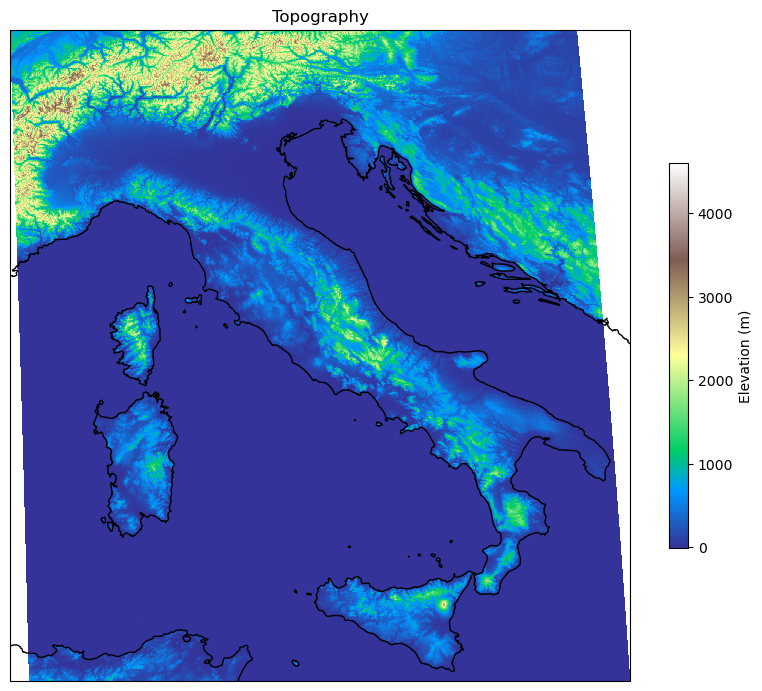

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

data = topography.values['elevation']

# Define the extent
extent = (topography.lon.min(), topography.lon.max(), topography.lat.min(), topography.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(topography.lon, topography.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot the data
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.terrain, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Elevation (m)')

# Set the title
plt.title('Topography')

# Show the plot
plt.show()


In [70]:
topography = pd.concat([
    load_topography(
        "/data1/data_prep/nasa_topo/topo.tiff",
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

topography

,elevation
station,
IT0854A,79.4308
IT0856A,25.7440
IT0858A,49.0000
IT1549A,170.0000
IT1698A,75.1120
IT1850A,56.3604
IT02258A,12.0000
IT0885A,26.1260
IT2249A,9.0000


## 3.X. Add external covariates

In [71]:
from cams_downscaling.readers.cams import load_cams

cams_path = config['paths']['cams']
cams_path = Path(cams_path, variable.lower(), region)

dates = observations.index.get_level_values('time').unique()

cams = load_cams(cams_path, dates=dates)

cams =  cams.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

cams.index = observations.sort_index().index
cams.columns = [v.upper() for v in cams.columns]

cams

NO2
time                station            
2022-01-01 00:00:00 IT02258A  13.524552
                    IT0611A    8.580558
                    IT0614A   10.735029
                    IT0618A   13.414124
                    IT0620A   11.971348
...                                 ...
2022-12-31 23:00:00 IT2264A   11.164440
                    IT2277A   50.361293
                    IT2278A   12.971291
                    IT2286A   14.229531
                    IT2316A   14.387962

[420480 rows x 1 columns]

In [72]:
from cams_downscaling.readers.era5 import load_era5

dates = observations.index.get_level_values('time').unique()

era5 = load_era5(Path(config['paths']['era5']), region, dates)

era5 = era5.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

era5.index = observations.sort_index().index

era5

blh      iews      inss
time                station                                 
2022-01-01 00:00:00 IT02258A  199.588164  0.024318 -0.016489
                    IT0611A    42.022208  0.032217 -0.002649
                    IT0614A    50.433422  0.023310 -0.007939
                    IT0618A    50.756283  0.019536 -0.002041
                    IT0620A    67.395062  0.014780 -0.013527
...                                  ...       ...       ...
2022-12-31 23:00:00 IT2264A    87.434313 -0.009911 -0.001797
                    IT2277A   119.442423 -0.007135 -0.005765
                    IT2278A    89.428241  0.035895 -0.013520
                    IT2286A    78.389794  0.033884 -0.018440
                    IT2316A   128.822213 -0.000995 -0.015062

[420480 rows x 3 columns]

In [73]:
"""import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.spatial import KDTree
from joblib import Parallel, delayed

def kriging_interpolation(points, obs, kriging=True):
    lats = points[:, 0]
    lons = points[:, 1]
    Z = points[:, -1]

    # KDTree interpolation
    tree = KDTree(points[:, :2])
    dist, idx = tree.query(obs[:, :2])

    if kriging:
        # If all points are the same, return the same value for all observations
        if len(set(Z)) == 1:
            return np.hstack([
                obs,
                points[idx][:, -1:],
                points[idx][:, -1:],
                dist[:, np.newaxis],
                np.zeros((len(obs), 1))])

        # Define the Kriging model
        OK = OrdinaryKriging(
            lats, lons, Z,
            coordinates_type='geographic',
            verbose=False,
            enable_plotting=False)

        # Perform the interpolation
        interp_values, ss = OK.execute('points', obs[:, 0], obs[:, 1])

        return np.hstack([
            obs,
            points[idx][:, -1:],
            interp_values[:, np.newaxis],
            dist[:, np.newaxis],
            ss[:, np.newaxis]])
    
    return np.hstack([
        obs,
        points[idx][:, -1:],
        dist[:, np.newaxis]])

def interpolate_points(x, variable, kriging=True):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[[
        'Latitude', 'Longitude',
        'elevation', f'{variable}_cams',
        variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    # Parallelize the interpolation process
    interpolated = Parallel(n_jobs=-1)(delayed(kriging_interpolation)(
        all_points[~mask_row], all_points[mask_row], kriging) for mask_row in mask)
    
    # Combine all results into a single DataFrame
    if kriging:
        return pd.DataFrame(
            np.vstack(interpolated),
            columns=[
                'Latitude', 'Longitude',
                'elevation', f'{variable}_cams',
                f'{variable}_obs', f'{variable}_kdtree', f'{variable}_kriging', 'dist', 'ss'])

    return pd.DataFrame(
        np.vstack(interpolated),
        columns=[
            'Latitude', 'Longitude',
            'elevation', f'{variable}_cams',
            f'{variable}_obs', f'{variable}_kdtree', 'dist'])

# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable.upper(),
    kriging=True).reset_index().drop(columns=['level_2'])

dataset"""

"import numpy as np\nimport pandas as pd\nfrom pykrige.ok import OrdinaryKriging\nfrom scipy.spatial import KDTree\nfrom joblib import Parallel, delayed\n\ndef kriging_interpolation(points, obs, kriging=True):\n    lats = points[:, 0]\n    lons = points[:, 1]\n    Z = points[:, -1]\n\n    # KDTree interpolation\n    tree = KDTree(points[:, :2])\n    dist, idx = tree.query(obs[:, :2])\n\n    if kriging:\n        # If all points are the same, return the same value for all observations\n        if len(set(Z)) == 1:\n            return np.hstack([\n                obs,\n                points[idx][:, -1:],\n                points[idx][:, -1:],\n                dist[:, np.newaxis],\n                np.zeros((len(obs), 1))])\n\n        # Define the Kriging model\n        OK = OrdinaryKriging(\n            lats, lons, Z,\n            coordinates_type='geographic',\n            verbose=False,\n            enable_plotting=False)\n\n        # Perform the interpolation\n        interp_values, ss 

In [74]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', 'elevation', f'{variable}_cams', variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, -1:],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=[
            'Latitude', 'Longitude',
            'elevation', f'{variable}_cams',
            f'{variable}_obs', f'{variable}_interp', 'dist'])
    
# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

dataset

/tmp/ipykernel_11588/901272225.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(


,time,cluster,Latitude,Longitude,elevation,NO2_cams,NO2_obs,NO2_interp,dist
0,2022-01-01 00:00:00,0,44.3949,8.9915,49.0000,19.164503,30.790000,49.48000,0.025355
1,2022-01-01 00:00:00,0,44.5186,8.8738,170.0000,22.804015,7.380000,28.23000,0.062342
2,2022-01-01 00:00:00,0,44.4049,8.9682,75.1120,21.085538,49.480000,30.79000,0.025355
3,2022-01-01 00:00:00,0,44.4182,8.9274,79.4308,23.324182,42.270000,39.21000,0.017243
4,2022-01-01 00:00:00,0,44.4076,8.9410,25.7440,22.592184,39.210000,42.27000,0.017243
...,...,...,...,...,...,...,...,...,...
306595,2022-12-31 23:00:00,6,37.0940,15.2087,152.4600,12.427401,9.766690,6.33479,0.053980
306596,2022-12-31 23:00:00,6,37.2184,15.2205,3.0800,12.474630,10.544216,7.43356,0.068974
306597,2022-12-31 23:00:00,6,37.1824,15.1288,230.0000,15.281953,6.941250,7.43356,0.067440
306598,2022-12-31 23:00:00,6,37.1561,15.1909,17.5244,14.456709,7.433560,9.76669,0.064601


In [75]:
((dataset['NO2_cams'] - dataset['NO2_obs'])**2).mean()**0.5

21.30587903239772

In [76]:
((dataset['NO2_interp'] - dataset['NO2_obs'])**2).mean()**0.5

20.150921688734947

In [77]:
"""import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.spatial import KDTree
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression

def kriging_interpolation(points, obs, kriging=True):
    lats = points[:, 0]
    lons = points[:, 1]
    elev = points[:, 2]
    Z = points[:, 3]

    # Perform linear regression on elevation
    reg = LinearRegression().fit(elev.reshape(-1, 1), Z)
    trend = reg.predict(elev.reshape(-1, 1))
    residuals = Z - trend

    # KDTree interpolation
    tree = KDTree(points[:, :3])
    dist, idx = tree.query(obs[:, :3])

    if kriging:
        # If all points are the same, return the same value for all observations
        if len(set(Z)) == 1:
            return np.hstack([
                obs,
                points[idx][:, 3:4],
                points[idx][:, 3:4],
                dist[:, np.newaxis],
                np.zeros((len(obs), 1))])

        # Define the Kriging model using residuals
        OK = OrdinaryKriging(
            lats, lons, residuals,
            variogram_model='linear',
            verbose=False,
            enable_plotting=False)

        # Perform the interpolation of residuals
        residual_interp_values, ss = OK.execute('points', obs[:, 0], obs[:, 1])
        
        # Add the regression trend to the interpolated residuals
        obs_elev = obs[:, 2]
        obs_trend = reg.predict(obs_elev.reshape(-1, 1))
        interp_values = residual_interp_values + obs_trend

        return np.hstack([
            obs,
            points[idx][:, 3:4],
            interp_values[:, np.newaxis],
            dist[:, np.newaxis],
            ss[:, np.newaxis]])
    
    return np.hstack([
        obs,
        points[idx][:, 3:4],
        dist[:, np.newaxis]])

def interpolate_points(x, variable, kriging=True):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', 'elevation', variable]].reset_index(drop=True)
    
    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    # Parallelize the interpolation process
    interpolated = Parallel(n_jobs=-1)(delayed(kriging_interpolation)(
        all_points[~mask_row], all_points[mask_row], kriging) for mask_row in mask)
    
    # Combine all results into a single DataFrame
    if kriging:
        return pd.DataFrame(
            np.vstack(interpolated),
            columns=['Latitude', 'Longitude', 'Elevation', f'{variable}_obs', f'{variable}_kdtree', f'{variable}_kriging', 'dist', 'ss'])

    return pd.DataFrame(
        np.vstack(interpolated),
        columns=['Latitude', 'Longitude', 'Elevation', f'{variable}_obs', f'{variable}_kdtree', 'dist'])

# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable.upper(),
    kriging=True).reset_index().drop(columns=['level_2'])

dataset"""

"import numpy as np\nimport pandas as pd\nfrom pykrige.ok import OrdinaryKriging\nfrom scipy.spatial import KDTree\nfrom joblib import Parallel, delayed\nfrom sklearn.linear_model import LinearRegression\n\ndef kriging_interpolation(points, obs, kriging=True):\n    lats = points[:, 0]\n    lons = points[:, 1]\n    elev = points[:, 2]\n    Z = points[:, 3]\n\n    # Perform linear regression on elevation\n    reg = LinearRegression().fit(elev.reshape(-1, 1), Z)\n    trend = reg.predict(elev.reshape(-1, 1))\n    residuals = Z - trend\n\n    # KDTree interpolation\n    tree = KDTree(points[:, :3])\n    dist, idx = tree.query(obs[:, :3])\n\n    if kriging:\n        # If all points are the same, return the same value for all observations\n        if len(set(Z)) == 1:\n            return np.hstack([\n                obs,\n                points[idx][:, 3:4],\n                points[idx][:, 3:4],\n                dist[:, np.newaxis],\n                np.zeros((len(obs), 1))])\n\n        # Defi

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = dataset.copy()

# Feature engineering: Create new features (examples)
data['hour'] = pd.to_datetime(data['time']).dt.hour
data['day'] = pd.to_datetime(data['time']).dt.day
data['month'] = pd.to_datetime(data['time']).dt.month
data['year'] = pd.to_datetime(data['time']).dt.year

# Define the features (X) and the target (y)
features = ['cluster', 'Latitude', 'Longitude', 'elevation', 'NO2_cams', 'NO2_interp', 'dist', 'hour', 'day', 'month', 'year']
#features = ['cluster', 'Latitude', 'Longitude', 'elevation', 'NO2_cams', 'NO2_kdtree', 'NO2_kriging', 'dist', 'ss', 'hour', 'day', 'month', 'year']
X = data[features]
y = data['NO2_obs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {mse**0.5}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 10.855888132525665
R² Score: 0.7128401958170958


In [79]:
from cams_downscaling.readers.topography import load_topography

topography = pd.concat([
    load_topography(
        config['paths']['topography'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

topography

,elevation
station,
IT0854A,79.4308
IT0856A,25.7440
IT0858A,49.0000
IT1549A,170.0000
IT1698A,75.1120
IT1850A,56.3604
IT02258A,12.0000
IT0885A,26.1260
IT2249A,9.0000


In [80]:
from cams_downscaling.readers.land_cover import load_corine

land_use = pd.concat([
    load_corine(
        config['paths']['land_cover'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate_discrete(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

land_use

,land
station,
IT0854A,2
IT0856A,2
IT0858A,2
IT1549A,21
IT1698A,2
IT1850A,2
IT02258A,12
IT0885A,1
IT2249A,12


In [81]:
from cams_downscaling.readers.population import load_pop

population = pd.concat([
    load_pop(
        config['paths']['population'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

population

,population
station,
IT0854A,222.392350
IT0856A,280.508502
IT0858A,35.174103
IT1549A,0.000000
IT1698A,250.653527
IT1850A,6.784648
IT02258A,0.000000
IT0885A,82.190059
IT2249A,0.000000


In [82]:
from cams_downscaling.readers.build_height import load_height

height = pd.concat([
    load_height(
        config['paths']['height'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

height

,height
station,
IT0854A,9.043833
IT0856A,10.067759
IT0858A,10.771292
IT1549A,0.000000
IT1698A,4.620212
IT1850A,0.786044
IT02258A,0.000000
IT0885A,6.390292
IT2249A,0.000000


In [83]:
from cams_downscaling.readers.era5_land import load_era5_land

dates = observations.index.get_level_values('time').unique()

era5_land = load_era5_land(Path(config['paths']['era5_land']), region, dates)

era5_land = era5_land.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

era5_land.index = observations.sort_index().index

era5_land

d2m           ssr         t2m  \
time                station                                          
2022-01-01 00:00:00 IT02258A   40.017252  9.555521e+05   40.195615   
                    IT0611A   280.575043  8.715984e+06  281.539558   
                    IT0614A   281.307245  8.708524e+06  282.152255   
                    IT0618A   223.581691  7.062000e+06  224.335450   
                    IT0620A   105.661049  3.233999e+06  105.959807   
...                                  ...           ...         ...   
2022-12-31 23:00:00 IT2264A     0.000000  0.000000e+00    0.000000   
                    IT2277A     0.000000  0.000000e+00    0.000000   
                    IT2278A    93.244680  9.477874e+05   93.368659   
                    IT2286A    95.281680  1.035107e+06   95.370069   
                    IT2316A   281.907140  8.558435e+06  283.928141   

                                        tp       v10       u10  
time                station                                     
2022-01-01 00:00:00 IT02258A  1.210691e-07 -0.292381  0.261429  
                    IT0611A   8.523463e-07 -0.093650  1.756724  
                    IT0614A   8.523463e-07 -0.496110  1.719208  
                    IT0618A   6.776144e-07 -0.064158  1.324876  
                    IT0620A   3.196303e-07 -0.463999  0.646554  
...                                    ...       ...       ...  
2022-12-31 23:00:00 IT2264A   0.000000e+00  0.000000  0.000000  
                    IT2277A   0.000000e+00  0.000000  0.000000  
                    IT2278A   1.371509e-03  0.477138 -0.453397  
                    IT2286A   1.243093e-03  0.562307 -0.391448  
                    IT2316A   1.710653e-06 -1.689918  0.888745  

[420480 rows x 6 columns]

In [85]:
from cams_downscaling.readers.roads import load_osm

roads = pd.concat([
    load_osm(
        f"{config['paths']['osm']}/italy.tif",
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate_discrete(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

roads

,roads
station,
IT0854A,6
IT0856A,6
IT0858A,0
IT1549A,0
IT1698A,3
IT1850A,0
IT02258A,0
IT0885A,6
IT2249A,0


# Model

He preparat aquesta part perque pogueu fer proves incorporant diferents datasets.

Em sembla que no cambiara gaire, pero bueno.

Simplement correu a partir de aquesta cel·la i només heu de modificar la cel·la de sota segons les dades que volgueu incorporar.

Per guardar-ho a sql no tinc clar com fer-ho, però els resultats del model estan a la ultima cel·la.

In [86]:
# Apply the function to the dataset
dataset = (
    observations
    .join(topography)
    .join(land_use)
    .join(era5)
    .join(era5_land)
    .join(population)
    .join(height)
    # .join(roads)
)
model_version = 107

dataset

NO2  Latitude  Longitude  cluster  \
time                station                                             
2022-01-01 00:00:00 IT02258A  16.664060   42.0424    11.8335        1   
                    IT0611A    8.590333   37.1824    15.1288        6   
                    IT0614A   19.625444   37.1561    15.1909        6   
                    IT0618A   22.034541   37.2184    15.2205        6   
                    IT0620A   21.732343   37.0984    15.2625        6   
...                                 ...       ...        ...      ...   
2022-12-31 23:00:00 IT2264A   23.185680   42.0969    11.7883        1   
                    IT2277A   16.700000   40.7989    14.1794        3   
                    IT2278A    5.990000   44.3329     8.5120        5   
                    IT2286A   16.470000   44.2618     8.4457        5   
                    IT2316A    8.262230   37.0963    15.1318        6   

                              elevation  land         blh      iews      inss  \
time                station                                                     
2022-01-01 00:00:00 IT02258A    12.0000    12  199.588164  0.024318 -0.016489   
                    IT0611A    230.0000    44   42.022208  0.032217 -0.002649   
                    IT0614A     17.5244     1   50.433422  0.023310 -0.007939   
                    IT0618A      3.0800     1   50.756283  0.019536 -0.002041   
                    IT0620A     71.0000     2   67.395062  0.014780 -0.013527   
...                                 ...   ...         ...       ...       ...   
2022-12-31 23:00:00 IT2264A      6.1452     1   87.434313 -0.009911 -0.001797   
                    IT2277A    151.0000    10  119.442423 -0.007135 -0.005765   
                    IT2278A      8.0000     2   89.428241  0.035895 -0.013520   
                    IT2286A      3.3400     5   78.389794  0.033884 -0.018440   
                    IT2316A    131.8600    20  128.822213 -0.000995 -0.015062   

                                     d2m           ssr         t2m  \
time                station                                          
2022-01-01 00:00:00 IT02258A   40.017252  9.555521e+05   40.195615   
                    IT0611A   280.575043  8.715984e+06  281.539558   
                    IT0614A   281.307245  8.708524e+06  282.152255   
                    IT0618A   223.581691  7.062000e+06  224.335450   
                    IT0620A   105.661049  3.233999e+06  105.959807   
...                                  ...           ...         ...   
2022-12-31 23:00:00 IT2264A     0.000000  0.000000e+00    0.000000   
                    IT2277A     0.000000  0.000000e+00    0.000000   
                    IT2278A    93.244680  9.477874e+05   93.368659   
                    IT2286A    95.281680  1.035107e+06   95.370069   
                    IT2316A   281.907140  8.558435e+06  283.928141   

                                        tp       v10       u10  population  \
time                station                                                  
2022-01-01 00:00:00 IT02258A  1.210691e-07 -0.292381  0.261429    0.000000   
                    IT0611A   8.523463e-07 -0.093650  1.756724    0.001132   
                    IT0614A   8.523463e-07 -0.496110  1.719208  163.488819   
                    IT0618A   6.776144e-07 -0.064158  1.324876    1.601103   
                    IT0620A   3.196303e-07 -0.463999  0.646554    7.511765   
...                                    ...       ...       ...         ...   
2022-12-31 23:00:00 IT2264A   0.000000e+00  0.000000  0.000000    0.166222   
                    IT2277A   0.000000e+00  0.000000  0.000000    0.798719   
                    IT2278A   1.371509e-03  0.477138 -0.453397  198.954437   
                    IT2286A   1.243093e-03  0.562307 -0.391448    0.000000   
                    IT2316A   1.710653e-06 -1.689918  0.888745    1.665113   

                                height  
time                station             
2022-01-01 00:00:00 IT02

In [87]:
from sklearn.model_selection import train_test_split

pairs = dataset.reset_index()[['time', 'cluster']]
pairs['time'] = pairs['time'].dt.date

train_split, test_split = train_test_split(pairs.drop_duplicates(), test_size=0.1, random_state=42)

train_set = set(train_split.itertuples(index=False, name=None))
test_set = set(test_split.itertuples(index=False, name=None))

train_dataset = dataset[[t in train_set for t in zip(dataset.index.get_level_values('time').date, dataset.cluster)]].copy()
test_dataset = dataset[[t in test_set for t in zip(dataset.index.get_level_values('time').date, dataset.cluster)]].copy()

In [88]:
dataset

NO2  Latitude  Longitude  cluster  \
time                station                                             
2022-01-01 00:00:00 IT02258A  16.664060   42.0424    11.8335        1   
                    IT0611A    8.590333   37.1824    15.1288        6   
                    IT0614A   19.625444   37.1561    15.1909        6   
                    IT0618A   22.034541   37.2184    15.2205        6   
                    IT0620A   21.732343   37.0984    15.2625        6   
...                                 ...       ...        ...      ...   
2022-12-31 23:00:00 IT2264A   23.185680   42.0969    11.7883        1   
                    IT2277A   16.700000   40.7989    14.1794        3   
                    IT2278A    5.990000   44.3329     8.5120        5   
                    IT2286A   16.470000   44.2618     8.4457        5   
                    IT2316A    8.262230   37.0963    15.1318        6   

                              elevation  land         blh      iews      inss  \
time                station                                                     
2022-01-01 00:00:00 IT02258A    12.0000    12  199.588164  0.024318 -0.016489   
                    IT0611A    230.0000    44   42.022208  0.032217 -0.002649   
                    IT0614A     17.5244     1   50.433422  0.023310 -0.007939   
                    IT0618A      3.0800     1   50.756283  0.019536 -0.002041   
                    IT0620A     71.0000     2   67.395062  0.014780 -0.013527   
...                                 ...   ...         ...       ...       ...   
2022-12-31 23:00:00 IT2264A      6.1452     1   87.434313 -0.009911 -0.001797   
                    IT2277A    151.0000    10  119.442423 -0.007135 -0.005765   
                    IT2278A      8.0000     2   89.428241  0.035895 -0.013520   
                    IT2286A      3.3400     5   78.389794  0.033884 -0.018440   
                    IT2316A    131.8600    20  128.822213 -0.000995 -0.015062   

                                     d2m           ssr         t2m  \
time                station                                          
2022-01-01 00:00:00 IT02258A   40.017252  9.555521e+05   40.195615   
                    IT0611A   280.575043  8.715984e+06  281.539558   
                    IT0614A   281.307245  8.708524e+06  282.152255   
                    IT0618A   223.581691  7.062000e+06  224.335450   
                    IT0620A   105.661049  3.233999e+06  105.959807   
...                                  ...           ...         ...   
2022-12-31 23:00:00 IT2264A     0.000000  0.000000e+00    0.000000   
                    IT2277A     0.000000  0.000000e+00    0.000000   
                    IT2278A    93.244680  9.477874e+05   93.368659   
                    IT2286A    95.281680  1.035107e+06   95.370069   
                    IT2316A   281.907140  8.558435e+06  283.928141   

                                        tp       v10       u10  population  \
time                station                                                  
2022-01-01 00:00:00 IT02258A  1.210691e-07 -0.292381  0.261429    0.000000   
                    IT0611A   8.523463e-07 -0.093650  1.756724    0.001132   
                    IT0614A   8.523463e-07 -0.496110  1.719208  163.488819   
                    IT0618A   6.776144e-07 -0.064158  1.324876    1.601103   
                    IT0620A   3.196303e-07 -0.463999  0.646554    7.511765   
...                                    ...       ...       ...         ...   
2022-12-31 23:00:00 IT2264A   0.000000e+00  0.000000  0.000000    0.166222   
                    IT2277A   0.000000e+00  0.000000  0.000000    0.798719   
                    IT2278A   1.371509e-03  0.477138 -0.453397  198.954437   
                    IT2286A   1.243093e-03  0.562307 -0.391448    0.000000   
                    IT2316A   1.710653e-06 -1.689918  0.888745    1.665113   

                                height  
time                station             
2022-01-01 00:00:00 IT02

In [89]:
permutations = pd.get_dummies(
    observations.groupby([observations.index.get_level_values('time').date, 'cluster'], group_keys=False)
    .apply(lambda x: x.sample(n).assign(i=range(n)), include_groups=False)
    .get('i').astype(str).reindex(observations.index)
    .groupby([observations.index.get_level_values('time').date, 'station'], group_keys=False)
    .apply(lambda x: x.ffill().bfill())
).add_prefix('perm_')

permutations

/tmp/ipykernel_11588/3054760628.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x: x.ffill().bfill())


perm_0  perm_1  perm_2  perm_3  perm_4
time                station                                         
2022-01-01 00:00:00 IT02258A   False    True   False   False   False
                    IT0611A    False    True   False   False   False
                    IT0614A    False   False   False   False   False
                    IT0618A    False   False   False   False   False
                    IT0620A     True   False   False   False   False
...                              ...     ...     ...     ...     ...
2022-12-31 23:00:00 IT2264A    False   False   False   False   False
                    IT2277A    False   False   False   False   False
                    IT2278A    False   False   False   False   False
                    IT2286A    False    True   False   False   False
                    IT2316A     True   False   False   False   False

[420480 rows x 5 columns]

In [90]:
external_variables = dataset.columns[4:].tolist()

external_variables

['elevation',
 'land',
 'blh',
 'iews',
 'inss',
 'd2m',
 'ssr',
 't2m',
 'tp',
 'v10',
 'u10',
 'population',
 'height']

In [91]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    station = x.index.get_level_values('station')
    x = x[[
        'Latitude', 'Longitude']
        + external_variables +
        [f'{variable}_cams', variable]].reset_index(drop=True)
    x.insert(2, 'station', station)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, -1:],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=[
            'Latitude', 'Longitude', 'station']
            + external_variables +
            [f'{variable}_cams',
            f'{variable}_obs', f'{variable}_interp', 'dist'])

train_dataset[f'{variable}_cams'] = cams[variable]
train_dataset = train_dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

test_dataset[f'{variable}_cams'] = cams[variable]
test_dataset = test_dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

train_dataset

/tmp/ipykernel_11588/1860317773.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_dataset = train_dataset.join(permutations).groupby(['time', 'cluster']).apply(
/tmp/ipykernel_11588/1860317773.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_dataset = test_dataset.join(permutations).groupby(['time', 'cluster']).apply(


,time,cluster,Latitude,Longitude,station,elevation,land,blh,iews,inss,...,t2m,tp,v10,u10,population,height,NO2_cams,NO2_obs,NO2_interp,dist
0,2022-01-01 00:00:00,0,44.5186,8.8738,IT1549A,170.0,21,71.106599,-0.023781,0.07132,...,279.065421,0.000134,1.167081,-0.855525,0.0,0.0,22.804015,7.38,28.23,0.062342
1,2022-01-01 00:00:00,0,44.4627,8.9014,IT1850A,56.3604,2,96.377243,-0.0196,0.049654,...,175.005315,0.000092,0.67579,-0.553194,6.784648,0.786044,24.383323,28.23,42.27,0.051539
2,2022-01-01 00:00:00,0,44.4076,8.941,IT0856A,25.744,2,135.517227,-0.013806,0.031628,...,21.216193,0.00001,0.071424,-0.071538,280.508502,10.067759,22.592184,39.21,42.27,0.017243
3,2022-01-01 00:00:00,0,44.3949,8.9915,IT0858A,49.0,2,144.139864,-0.012417,0.020423,...,0.0,0.0,0.0,0.0,35.174103,10.771292,19.164503,30.79,49.48,0.025355
4,2022-01-01 00:00:00,1,42.0736,11.8159,IT2253A,30.84,2,188.450477,0.023796,-0.016824,...,33.116179,0.0,-0.240886,0.215385,8.76547,1.092303,12.681659,30.20291,44.3194,0.02244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208531,2022-12-31 23:00:00,5,44.2725,8.4389,IT1143A,6.2,2,79.123569,0.036672,-0.019268,...,125.893643,0.001641,0.742276,-0.516733,0.859057,0.04202,13.913026,26.78,16.47,0.012678
208532,2022-12-31 23:00:00,6,37.0963,15.1318,IT2316A,131.86,20,128.822213,-0.000995,-0.015062,...,283.928141,0.000002,-1.689918,0.888745,1.665113,0.520902,14.387962,8.26223,9.76669,0.076934
208533,2022-12-31 23:00:00,6,37.0984,15.2625,IT0620A,71.0,2,234.259348,-0.000655,-0.013278,...,106.708654,0.000001,-0.790225,0.305287,7.511765,0.570823,10.253758,6.33479,14.9524,0.027748
208534,2022-12-31 23:00:00,6,37.094,15.2087,IT1440A,152.46,1,193.950862,-0.000769,-0.014083,...,259.825037,0.000002,-1.940406,0.741152,0.168417,0.049184,12.427401,9.76669,6.33479,0.05398


In [92]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def prepare_dataset(data):
    data['hour'] = pd.to_datetime(data['time']).dt.hour
    data['day'] = pd.to_datetime(data['time']).dt.day
    data['month'] = pd.to_datetime(data['time']).dt.month
    data['year'] = pd.to_datetime(data['time']).dt.year

    features = [
        'cluster', 'Latitude', 'Longitude'] + external_variables + [
        'NO2_cams', 'NO2_interp', 'dist', 'hour', 'day', 'month', 'year']

    X = data[features]
    y = data['NO2_obs']

    return X, y

X_train, y_train = prepare_dataset(train_dataset)
X_test, y_test = prepare_dataset(test_dataset)

# Initialize and train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {mse**0.5}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 10.308670482374632
R² Score: 0.7437490198647668


In [93]:
from cams_downscaling.datatypes import DatabaseTSPD

stations=test_dataset.station
date=test_dataset.time
points=test_dataset[['Latitude', 'Longitude']]
values=y_pred

db = DatabaseTSPD(stations, date, points, values)
db.values

model_version=99999
db.save_sql(model_version=model_version, drop_previous=True)

OperationalError: (2003, "Can't connect to MySQL server on '127.0.0.1:3306' (111)")

In [ ]:
version_tracker = {
    '100': ['elevation',
        'land'],
    '101': ['elevation',
        'land',
        'blh',
        'iews',
        'inss',
        'd2m',
        'ssr',
        't2m',
        'tp',
        'v10',
        'u10'],
    '102': ['elevation',
        'land',
        'population'],
    '103': ['elevation',
        'land',
        'height'],
    '104': ['elevation',
        'land',
        'blh',
        'iews',
        'inss',
        'd2m',
        'ssr',
        't2m',
        'tp',
        'v10',
        'u10',
        'population',
        'height'],
    '105': [],
    '106': ['elevation'],
    '107': ['land']
}